In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd

import dask

from python import climate_utils as cu
from python import utils as pu

In [19]:
import salem

In [4]:
import xarray as xr

In [20]:
pu.tgw_path

'/home/shared/vs498_0001/im3_hyperfacets_tgw'

In [21]:
tgw = salem.open_wrf_dataset('/home/shared/vs498_0001/im3_hyperfacets_tgw/historical_1980_2019/hourly/tgw_wrf_historical_hourly_1980-01-01_01_00_00.nc')

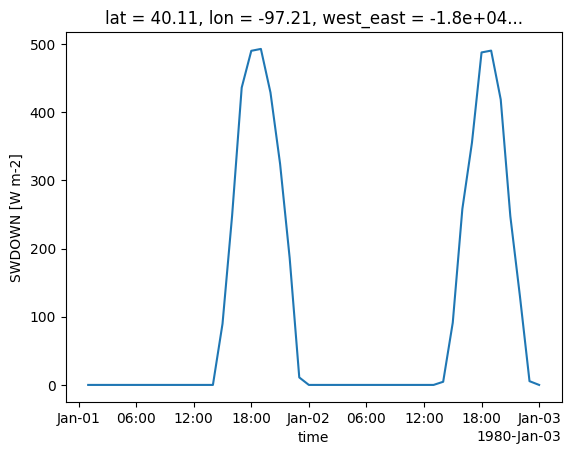

In [37]:
tgw['SWDOWN'].isel(south_north=150, west_east=210)[:48].plot()

In [4]:
df = pd.read_csv('/home/fs01/dcl257/data/nrel-sind/ny-pv-2006/Actual_42.85_-77.35_2006_DPV_18MW_5_Min.csv')

In [5]:
df['datetime'] = pd.to_datetime(df['LocalTime'], format='%m/%d/%y %H:%M')

In [10]:
# Convert to UTC
df['datetime'] = df['datetime'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')
df['datetime'] = df['datetime'].dt.tz_convert('UTC')

In [24]:
df_daily = df.set_index('datetime').resample('1h').sum()['Power(MW)'].reset_index()

<Axes: >

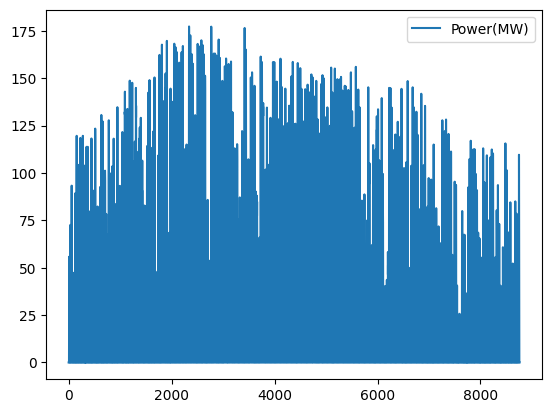

In [25]:
df_daily.plot(y='Power(MW)')